# 1. MMDetection 설치 및 Oxford Pet 데이터셋 다운로드

## MMDetection 설치

In [ ]:
# MMCV 설치
# torch 버전이 달라지면 달라진 버전을 입력해주어야 함
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
# MMDetection git clolne
!git clone https://github.com/open-mmlab/mmdetection.git
# MMDetection 설치
!cd mmdetection; python setup.py install

In [1]:
# 임포트하기 전에 '런타임 다시 시작'을 해야 함
from mmdet.apis import init_detector, inference_detector
import mmcv

## Oxford Pet 데이터셋 다운로드

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-04-05 04:54:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  21.9MB/s    in 36s     

2022-04-05 04:55:01 (20.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-04-05 04:55:01--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.7MB/s    in 1.7s    

2022-04-05 04:55:03 (10.7 M

In [3]:
# /content/data 디렉터리 생성
!mkdir /content/data
# /content/data 디렉터리에 다운로드 받은 압축 파일 풀기
!tar -xvf images.tar.gz -C /content/data > /dev/null
!tar -xvf annotations.tar.gz -C /content/data > /dev/null

# 2. Oxford Pet 데이터 둘러보기

In [ ]:
!ls -lia ./data/images/Abyssinian*.jpg

In [ ]:
!ls -lia ./data/annotations/xmls/Abyssinian*.xml

In [6]:
!cat ./data/annotations/xmls/Abyssinian_1.xml

<annotation><folder>OXIIIT</folder><filename>Abyssinian_1.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>600</width><height>400</height><depth>3</depth></size><segmented>0</segmented><object><name>cat</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>333</xmin><ymin>72</ymin><xmax>425</xmax><ymax>158</ymax></bndbox><difficult>0</difficult></object></annotation>


In [7]:
import glob
import xml.etree.ElementTree as ET

def get_bboxes_from_xml_temp(xml_file):
  '''annotation xml을 파싱해서 경계 박스 정보 추출'''
  tree = ET.parse(xml_file) # xml을 파싱해서 트리 생성 ---①
  root = tree.getroot() # 트리의 루트 ---②
  object_names = [] # 객체명
  bboxes = [] # 경계 박스 좌표
   
  # 트리에 있는 모든 'object' Element를 찾아 순회 ---③
  for obj in root.findall('object'): 
    object_name = obj.find('name').text # <name> 태그의 문자열
    bbox = obj.find('bndbox') # 경계 박스
    x_min = int(bbox.find('xmin').text)
    y_min = int(bbox.find('ymin').text)
    x_max = int(bbox.find('xmax').text)
    y_max = int(bbox.find('ymax').text)

    object_names.append(object_name)
    bboxes.append([x_min, y_min, x_max, y_max])

  return object_names, bboxes

In [8]:
get_bboxes_from_xml_temp('./data/annotations/xmls/Abyssinian_1.xml')

(['cat'], [[333, 72, 425, 158]])

# 3. 데이터 준비

In [9]:
# 훈련, 검증용 annotation 메타 파일
!cd ./data/annotations
!cat trainval.txt

cat: trainval.txt: No such file or directory


In [10]:
import pandas as pd

pet_df = pd.read_csv('./data/annotations/trainval.txt', sep=' ', header=None, names=['img_name', 'class_id', 'etc1', 'etc2'])
pet_df.head()

,img_name,class_id,etc1,etc2
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [ ]:
pet_df['class_id'].value_counts()

In [12]:
pet_df['class_name'] = pet_df['img_name'].apply(lambda x:x[:x.rfind('_')])
pet_df.head()

,img_name,class_id,etc1,etc2,class_name
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian
4,Abyssinian_104,1,1,1,Abyssinian


In [13]:
x = 'Abyssinian_100'
print(x.rfind('_')) # '_'까지 인덱스
print(x[:x.rfind('_')]) # 객체 클래스명

10
Abyssinian


In [14]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(pet_df, test_size=0.1, stratify=pet_df['class_id'], random_state=42)

In [15]:
print(train_df['class_id'].value_counts(), val_df['class_id'].value_counts())

5     90
20    90
14    90
25    90
30    90
29    90
15    90
21    90
1     90
7     90
17    90
31    90
28    90
11    90
6     90
19    90
34    90
18    90
9     90
2     90
3     90
16    90
32    90
4     90
35    90
10    90
24    90
27    90
26    90
37    90
22    90
36    90
33    89
8     87
13    86
23    86
12    84
Name: class_id, dtype: int64 3     10
4     10
5     10
36    10
22    10
29    10
35    10
34    10
37    10
14    10
24    10
28    10
25    10
32    10
2     10
21    10
30    10
10    10
6     10
17    10
7     10
20    10
19    10
23    10
1     10
33    10
27    10
16    10
31    10
11    10
15    10
18    10
9     10
13    10
26    10
8      9
12     9
Name: class_id, dtype: int64


In [16]:
# img_name순으로 정렬
train_df = train_df.sort_values(by='img_name')
val_df = val_df.sort_values(by='img_name')

In [17]:
# ann_file로 주어지는 메타파일은 되도록 최상단 디렉터리에 저장하는 게 바람직
train_df['img_name'].to_csv('./data/train.txt', sep=' ', header=False, index=False)
val_df['img_name'].to_csv('./data/val.txt', sep=' ', header=False, index=False)

In [18]:
# 훈련 annotation 보기
!cat ./data/train.txt

Abyssinian_10
Abyssinian_100
Abyssinian_101
Abyssinian_102
Abyssinian_103
Abyssinian_104
Abyssinian_105
Abyssinian_106
Abyssinian_107
Abyssinian_108
Abyssinian_109
Abyssinian_11
Abyssinian_110
Abyssinian_111
Abyssinian_112
Abyssinian_114
Abyssinian_115
Abyssinian_116
Abyssinian_117
Abyssinian_118
Abyssinian_12
Abyssinian_120
Abyssinian_121
Abyssinian_122
Abyssinian_123
Abyssinian_124
Abyssinian_125
Abyssinian_126
Abyssinian_127
Abyssinian_128
Abyssinian_129
Abyssinian_13
Abyssinian_130
Abyssinian_131
Abyssinian_132
Abyssinian_133
Abyssinian_134
Abyssinian_135
Abyssinian_136
Abyssinian_137
Abyssinian_138
Abyssinian_139
Abyssinian_14
Abyssinian_140
Abyssinian_141
Abyssinian_142
Abyssinian_143
Abyssinian_144
Abyssinian_145
Abyssinian_146
Abyssinian_148
Abyssinian_149
Abyssinian_15
Abyssinian_150
Abyssinian_151
Abyssinian_152
Abyssinian_153
Abyssinian_154
Abyssinian_155
Abyssinian_157
Abyssinian_158
Abyssinian_159
Abyssinian_16
Abyssinian_160
Abyssinian_161
Abyssinian_164
Abyssinian_165
Ab

## 데이터셋을 중립 데이터 형태로 변환

In [19]:
def get_bboxes_from_xml(anno_dir, xml_file):
  '''annotation xml을 파싱해서 경계 박스 정보 추출'''
  anno_xml_file = os.path.join(anno_dir, xml_file)
  tree = ET.parse(anno_xml_file) # xml을 파싱해서 트리 생성
  root = tree.getroot() # 트리의 루트
  object_names = [] # 객체명
  bboxes = [] # 경계 박스 좌표

  # 트리에 있는 모든 'object' Element를 찾아 순회
  for obj in root.findall('object'):
    # 객체 클래스명은 파일명에서 추출 ---①
    object_name = xml_file[:xml_file.rfind('_')]
    bbox = obj.find('bndbox') # 경계 박스
    x_min = int(bbox.find('xmin').text)
    y_min = int(bbox.find('ymin').text)
    x_max = int(bbox.find('xmax').text)
    y_max = int(bbox.find('ymax').text)
    
    object_names.append(object_name)
    bboxes.append([x_min, y_min, x_max, y_max])

  return object_names, bboxes

In [20]:
import copy
import os
import numpy as np
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
import cv2

# 클래스는 pet_df의 'class_name' 열에 있는 고윳값으로 지정
PET_CLASSES = pet_df['class_name'].unique().tolist()

@DATASETS.register_module(force=True) # PetDataset 객체를 MMDetection 프레임워크에 등록
class PetDataset(CustomDataset):
  CLASSES = PET_CLASSES # 클래스 레이블 지정 ---①

  # CustomDataset의 load_annotations를 오버라이딩(재정의)
  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)} # {클래스명: 클래스ID}로 구성된 딕셔너리
    image_id_list = mmcv.list_from_file(self.ann_file) # 이미지ID 리스트 
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = [] # 포맷 중립 데이터를 담을 리스트 객체

    # image_id_list를 순회하며 이미지마다 포맷 중립 데이터로 변환
    for image_id in image_id_list:
      filename = f'{self.img_prefix}/{image_id}.jpg' # 파일명

      # filename 이미지를 직접 불러와 원본 이미지의 너비, 높이 구하기 
      img = cv2.imread(filename)
      height, width = img.shape[0], img.shape[1] # 이미지 높이와 너비

      # 개별 이미지의 annotation 정보 저장용 딕셔너리 생성 
      data_info = {'filename': str(image_id) + '.jpg', # 파일명(확장자 포함)
                   'width': width,   # 이미지 너비
                   'height': height} # 이미지 높이

      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      # 개별 annotation 파일을 한 line 씩 읽어서 list 로드( annotation XML파일이 xmls 아래 있음에 유의)
      anno_xml_file = os.path.join(label_prefix, 'xmls/' + str(image_id) + '.xml')

      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외 
      if not os.path.exists(anno_xml_file):
          continue
      
      anno_dir = os.path.join(label_prefix, 'xmls')
      # get_bboxes_from_xml() 함수를 이용해 개별 XML 파일에 있는 이미지의 객체명과 경계 박스 좌표를 list 객체로 생성 
      object_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id) + '.xml')
                  
      gt_bboxes = []        # 실제 경계 박스
      gt_labels = []        # 실제 클래스 레이블명
      gt_bboxes_ignore = [] # 훈련에 사용하지 않을 경계 박스
      gt_labels_ignore = [] # 훈련에 사용하지 않을 클래스 레이블명

      # 경계 박스와 클래스 레이블명 저장
      for object_name, bbox in zip(object_names, bboxes):
        # 만약 object_name이 객체 클래스명이면, gt_bboxes와 gt_labels에 추가
        # 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if object_name in cat2label:
            gt_bboxes.append(bbox)
            gt_labels.append(cat2label[object_name]) # gt_labels에는 class id를 저장
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1) # 객체가 아니면 class_id는 -1(배경이라는 뜻)
      
      # 이미지별 annotation 정보를 갖는 딕셔너리 생성
      anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.compat.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.compat.long)
      }
      
      data_info.update(ann=anno) # data_info에 anno 정보 업데이트
      data_infos.append(data_info) # data_infos에 data_info 추가

    return data_infos # 중립 데이터 형태로 변환한 데이터셋 반환

## 디버깅을 위한 데이터셋 클래스

In [21]:
class PetDataset_debug():
  ''' 디버깅 용도로 CustomDataset을 흉내낸 클래스를 생성하여 다양한 테스트 수행 가능 '''
  CLASSES = PET_CLASSES
  # 생성자 함수 생성.---①
  def __init__(self, data_root, ann_file, img_prefix):
      self.data_root = data_root
      self.ann_file = os.path.join(data_root, ann_file)
      self.img_prefix = os.path.join(data_root, img_prefix)
      self.data_infos = self.load_annotations(self.ann_file)

  def load_annotations(self, ann_file):
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_id_list = mmcv.list_from_file(self.ann_file) 
    # 포맷 중립 데이터를 담을 list 객체
    data_infos = [] # 포맷 중립 데이터를 담을 리스트 객체

    # image_id_list를 순회하며 이미지마다 포맷 중립 데이터로 변환
    for image_id in image_id_list:
      filename = f'{self.img_prefix}/{image_id}.jpg' # 파일명

      # filename 이미지를 직접 불러와 원본 이미지의 너비, 높이 구하기 
      img = cv2.imread(filename)
      height, width = img.shape[0], img.shape[1] # 이미지 높이와 너비

      # 개별 이미지의 annotation 정보 저장용 딕셔너리 생성 
      data_info = {'filename': str(image_id) + '.jpg', # 파일명(확장자 포함)
                   'width': width,   # 이미지 너비
                   'height': height} # 이미지 높이

      # 개별 annotation XML 파일이 있는 서브 디렉토리의 prefix 변환 
      label_prefix = self.img_prefix.replace('images', 'annotations')
      # 개별 annotation 파일을 한 line 씩 읽어서 list 로드( annotation XML파일이 xmls 아래 있음에 유의)
      anno_xml_file = os.path.join(label_prefix, 'xmls/' + str(image_id) + '.xml')

      # 메타 파일에는 이름이 있으나 실제로는 존재하지 않는 XML이 있으므로 이는 제외 
      if not os.path.exists(anno_xml_file):
          continue
      
      anno_dir = os.path.join(label_prefix, 'xmls')
      # get_bboxes_from_xml() 함수를 이용해 개별 XML 파일에 있는 이미지의 객체명과 경계 박스 좌표를 list 객체로 생성 
      object_names, bboxes = get_bboxes_from_xml(anno_dir, str(image_id) + '.xml')
                  
      gt_bboxes = []        # 실제 경계 박스
      gt_labels = []        # 실제 클래스 레이블명
      gt_bboxes_ignore = [] # 훈련에 사용하지 않을 경계 박스
      gt_labels_ignore = [] # 훈련에 사용하지 않을 클래스 레이블명

      # 경계 박스와 클래스 레이블명 저장
      for object_name, bbox in zip(object_names, bboxes):
        # 만약 object_name이 객체 클래스명이면, gt_bboxes와 gt_labels에 추가
        # 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if object_name in cat2label:
            gt_bboxes.append(bbox)
            gt_labels.append(cat2label[object_name]) # gt_labels에는 class id를 저장
        else:
            gt_bboxes_ignore.append(bbox)
            gt_labels_ignore.append(-1) # 객체가 아니면 class_id는 -1(배경이라는 뜻)
      
      # 이미지별 annotation 정보를 갖는 딕셔너리 생성
      anno = {
        'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
        'labels': np.array(gt_labels, dtype=np.compat.long),
        'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
        'labels_ignore': np.array(gt_labels_ignore, dtype=np.compat.long)
      }
      
      data_info.update(ann=anno) # data_info에 anno 정보 업데이트
      data_infos.append(data_info) # data_infos에 data_info 추가

    return data_infos # 중립 데이터 형태로 변환한 데이터셋 반환

In [22]:
# 디버깅 용도의 클래스 생성
train_debug = PetDataset_debug(data_root='/content/data', ann_file='train.txt', img_prefix='images')

# 첫 두 개 데이터만 출력
print(train_debug.data_infos[:2]) 

[{'filename': 'Abyssinian_10.jpg', 'width': 375, 'height': 500, 'ann': {'bboxes': array([[ 72., 105., 288., 291.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}, {'filename': 'Abyssinian_100.jpg', 'width': 394, 'height': 500, 'ann': {'bboxes': array([[151.,  71., 335., 267.]], dtype=float32), 'labels': array([0]), 'bboxes_ignore': array([], shape=(0, 4), dtype=float32), 'labels_ignore': array([], dtype=int64)}}]


# 4. Config 설정

In [23]:
# 사전 훈련 모델을 다운로드 받기 위해 mmdetection/checkpoints 디렉터리 생성 
!cd mmdetection; mkdir checkpoints
# 사전 훈련된 Faster R-CNN 다운로드
!wget -O ./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-04-05 04:55:25--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

./mmdetection/check 100%[===================>] 159.54M  11.5MB/s    in 14s     

2022-04-05 04:55:40 (11.4 MB/s) - ‘./mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [24]:
# config 파일 설정
config_file = './mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# 다운로드 받은 사전 훈련 모델을 checkpoint로 설정
checkpoint_file = './mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [25]:
from mmcv import Config

cfg = Config.fromfile(config_file)

##### Oxford Pet 데이터는 훈련하는 데 시간이 오래 걸리므로 훈련된 모델을 구글 드라이브에 저장

In [26]:
# 구글 드라이브 접근을 위한 Mount 적용
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
!mkdir "/content/gdrive/My Drive/pet_work_dir"

mkdir: cannot create directory ‘/content/gdrive/My Drive/pet_work_dir’: File exists


In [28]:
from mmdet.apis import set_random_seed

# 데이터셋의 환경 파라미터 수정
cfg.dataset_type = 'PetDataset'
cfg.data_root = '/content/data/'

# train, val, test 데이터셋에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정
cfg.data.train.type = 'PetDataset'
cfg.data.train.data_root = '/content/data/'
# MMDetection 요구에 따라 annotation 파일은 하나여야 함
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'PetDataset'
cfg.data.val.data_root = '/content/data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'images'

# 클래스 개수 수정 (초기값=80)
cfg.model.roi_head.bbox_head.num_classes = 37
# 사전 훈련 모델 (상대 경로이므로 root 디렉터리 = mmdetection) 
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉터리 설정 (상대 경로) 
cfg.work_dir = '/content/gdrive/My Drive/pet_work_dir'

cfg.optimizer.lr = 0.02 / 8 # 학습률 변경 환경 파라미터 설정 
cfg.lr_config.warmup = None # 웜업 미설정
cfg.log_config.interval = 5 # 로그 출력 인터벌 

cfg.runner.max_epochs = 5 # 에폭

# 커스텀 데이터셋을 사용하므로 그에 따른 평가 지표로 수정
cfg.evaluation.metric = 'mAP'
# 평가 인터벌 설정 (평가 시간을 줄이기 위해)
cfg.evaluation.interval = 5
# 체크포인트 인터벌 설정 (저장 용량을 줄이기 위해)
cfg.checkpoint_config.interval = 5

# 배치 크기 설정(단일 GPU별 배치 크기로 설정됨)
cfg.data.samples_per_gpu = 4

# 시드값 설정
cfg.seed = 0 
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# config 설정 시마다 policy값이 없어지는 버그 때문에 재설정 
cfg.lr_config.policy='step'

In [29]:
# 수정한 config를 보려면 주석 풀고 아래 코드 실행
# print(cfg.pretty_text)

# 5. 모델 훈련

In [30]:
from mmdet.datasets import build_dataset

# config에 설정된 주요 값으로 CustomDataset 생성 (훈련용 데이터셋)
datasets = [build_dataset(cfg.data.train)]

/usr/local/lib/python3.7/dist-packages/mmdet-2.23.0-py3.7.egg/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


In [31]:
datasets

[
 PetDataset Train dataset with number of images 3303, and instance counts: 
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | category              | count | category                | count | category                      | count | category            | count | category                        | count |
 +-----------------------+-------+-------------------------+-------+-------------------------------+-------+---------------------+-------+---------------------------------+-------+
 | 0 [Abyssinian]        | 89    | 1 [american_bulldog]    | 90    | 2 [american_pit_bull_terrier] | 90    | 3 [basset_hound]    | 90    | 4 [beagle]                      | 90    |
 | 5 [Bengal]            | 89    | 6 [Birman]              | 90    | 7 [Bombay]                    | 87    | 8 [boxer]           | 90    | 9 [British_Shorthair]           | 90    |
 | 10 [chihuahua]

In [32]:
from mmdet.models import build_detector

# 훈련, 테스트 config를 반영해 모델 생성
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [ ]:
from mmdet.apis import train_detector

%cd mmdetection

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

train_detector(model, datasets, cfg, distributed=False, validate=True) # 모델 훈련

/content/mmdetection


2022-04-05 05:00:33,132 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-04-05 05:00:33,256 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([38, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([38]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([148, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([148]).
2022-04-05 05:00:33,262 - mmdet - INFO - Start running, host: root@06eef5551717, work_dir: /conten

# 6. 훈련된 모델로 inference 수행

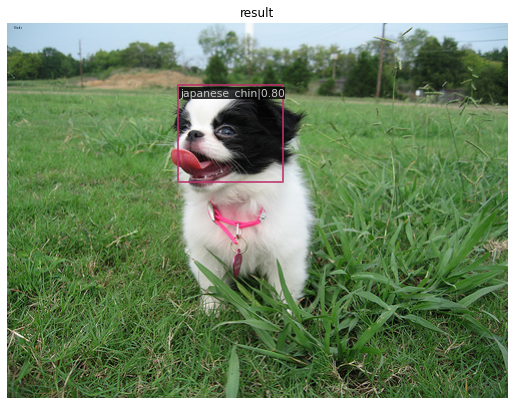

In [67]:
from mmdet.apis import show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/data/images/japanese_chin_50.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3);

In [ ]:
result

## Checkpoint에 저장된 모델을 로딩해서 Inference 수행

load checkpoint from local path: /content/gdrive/My Drive/pet_work_dir/epoch_5.pth


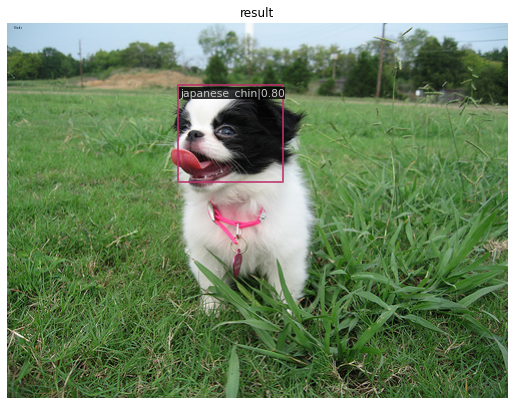

In [68]:
# checkpoint에 저장된 모델 파일
checkpoint_file = '/content/gdrive/My Drive/pet_work_dir/epoch_5.pth'

# checkpoint에 저장된 모델 파일을 활용해 모델 생성, 이때 Config는 앞서 오버라이딩한 config 사용
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

# BGR Image 사용 
img = cv2.imread('/content/data/images/japanese_chin_50.jpg')

# 여기서 이미지 array 대신 이미지 경로를 전달하면 오류 발생
result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.3);

## 여러 이미지를 활용해 Inference 수행

In [71]:
val_df

,img_name,class_id,etc1,etc2,class_name,img_path
1895,Abyssinian_1,1,1,1,Abyssinian,/content/data/images/Abyssinian_1.jpg
14,Abyssinian_113,1,1,1,Abyssinian,/content/data/images/Abyssinian_113.jpg
20,Abyssinian_119,1,1,1,Abyssinian,/content/data/images/Abyssinian_119.jpg
1856,Abyssinian_156,1,1,1,Abyssinian,/content/data/images/Abyssinian_156.jpg
1867,Abyssinian_168,1,1,1,Abyssinian,/content/data/images/Abyssinian_168.jpg
...,...,...,...,...,...,...
3639,yorkshire_terrier_154,37,2,25,yorkshire_terrier,/content/data/images/yorkshire_terrier_154.jpg
3640,yorkshire_terrier_155,37,2,25,yorkshire_terrier,/content/data/images/yorkshire_terrier_155.jpg
3662,yorkshire_terrier_175,37,2,25,yorkshire_terrier,/content/data/images/yorkshire_terrier_175.jpg
3676,yorkshire_terrier_188,37,2,25,yorkshire_terrier,/content/data/images/yorkshire_terrier_188.jpg


In [72]:
val_df['img_path'] = '/content/data/images/' + val_df['img_name'] + '.jpg'
val_df.head()

,img_name,class_id,etc1,etc2,class_name,img_path
1895,Abyssinian_1,1,1,1,Abyssinian,/content/data/images/Abyssinian_1.jpg
14,Abyssinian_113,1,1,1,Abyssinian,/content/data/images/Abyssinian_113.jpg
20,Abyssinian_119,1,1,1,Abyssinian,/content/data/images/Abyssinian_119.jpg
1856,Abyssinian_156,1,1,1,Abyssinian,/content/data/images/Abyssinian_156.jpg
1867,Abyssinian_168,1,1,1,Abyssinian,/content/data/images/Abyssinian_168.jpg


In [73]:
val_df[val_df['img_path'].str.contains('japanese_chin')]['img_path'].values

array(['/content/data/images/japanese_chin_103.jpg',
       '/content/data/images/japanese_chin_111.jpg',
       '/content/data/images/japanese_chin_113.jpg',
       '/content/data/images/japanese_chin_126.jpg',
       '/content/data/images/japanese_chin_135.jpg',
       '/content/data/images/japanese_chin_141.jpg',
       '/content/data/images/japanese_chin_173.jpg',
       '/content/data/images/japanese_chin_188.jpg',
       '/content/data/images/japanese_chin_189.jpg',
       '/content/data/images/japanese_chin_190.jpg'], dtype=object)

In [74]:
val_paths = val_df[val_df['img_path'].str.contains('japanese_chin')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

In [75]:
type(val_imgs), len(val_imgs), val_imgs[0].shape

(list, 10, (390, 500, 3))

In [76]:
results = inference_detector(model_ckpt, val_imgs)

In [77]:
len(results), len(results[0]), results

(10,
 37,
 [[array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([[4.8923111e+01, 4.8671429e+01, 4.0660876e+02, 3.2636331e+02,
           1.7531835e-01]], dtype=float32),
   array([[ 62.94252  ,  66.0191   , 417.71817  , 312.2294   ,   0.7598796]],
         dtype=float32),
   array([], shape=(0, 5), dtype=float32),
   array([], shape=(0, 5), dtype=float32)

In [78]:
PET_CLASSES = pet_df['class_name'].unique().tolist()
labels_to_names_seq = {i:k for i, k in enumerate(PET_CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3):
  '''모델과 원본 이미지 array, 필터링할 신뢰도 임계값을 인자로 갖는 inference 시각화 함수'''
  img_array_copy = img_array.copy() # image_array 복사
  bbox_color=(0, 255, 0) # 경계 박스 색상
  text_color=(0, 0, 255) # 텍스트 색상

  # Inference 수행
  # results는 2차원 array(형상=(객체 개수, 5)) 80개를 갖는 리스트
  results = inference_detector(model, img_array)

  # 80개의 array를 원소로 갖는 results 리스트를 순회하며 개별 2차원 array를 추출하고 이를 바탕으로 이미지 시각화 
  # results 리스트의 위치 index가 COCO에 매핑된 클래스 id. 여기서는 result_idx가 클래스 id임
  ## 개별 2차원 array에는 객체별 좌표와 객체 신뢰도 점수가 있음
  for result_idx, result in enumerate(results):
    if len(result) == 0: # 개별 2차원 array가 비어있으면 건너뛰기
      continue
    
    # 2차원 array에서 5번째 열의 값이 신뢰도 점수이며, 이 값이 신뢰도 임계값(score_threshold)보다 높은 값만 추출
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 객체 클래스별로 탐지된 여러 개 객체 정보가 2차원 array에 담겨 있으며,
    # 이 2차원 array 개수만큼 순회하며 개별 객체의 좌표값 추출
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출
      xmin = int(result_filtered[i, 0])
      ymin = int(result_filtered[i, 1])
      xmax = int(result_filtered[i, 2])
      ymax = int(result_filtered[i, 3])

      obj_class = labels_to_names_seq[result_idx] # 객체 클래스명
      confidence_score = result_filtered[i, 4] # 신뢰도 점수
      
      caption = f'{obj_class}: {confidence_score:.4f}' # 경계 박스 위에 표시할 텍스트 캡션
      cv2.rectangle(img_array_copy, (xmin, ymin), (xmax, ymax), color=bbox_color, thickness=2) # 경계 박스 표시
      cv2.putText(img_array_copy, caption, (int(xmin), int(ymin - 7)), # 텍스트 표시
                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 1) 

  return img_array_copy

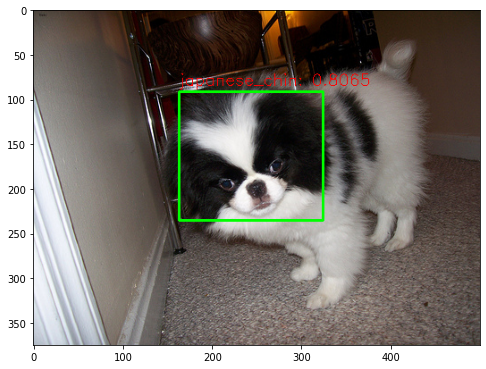

In [86]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/data/images/japanese_chin_25.jpg')

detected_img = get_detected_img(model, img_arr, score_threshold=0.3)
# 반환 결과가 BGR 형태라서 출력할 때는 RGB 형태로 변환해야 함
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB) # BGR을 RGB 형태로 변경

plt.figure(figsize=(8, 8))
plt.imshow(detected_img);

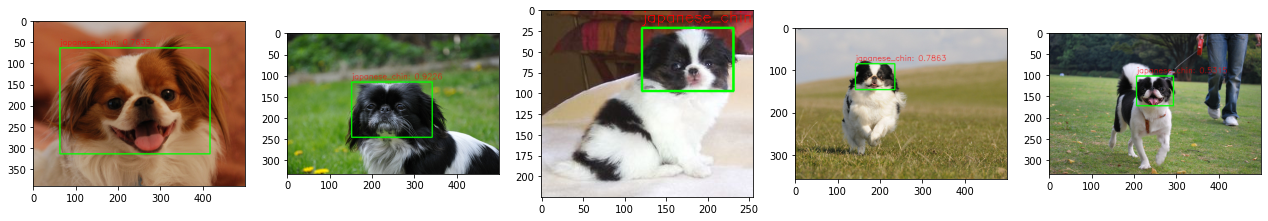

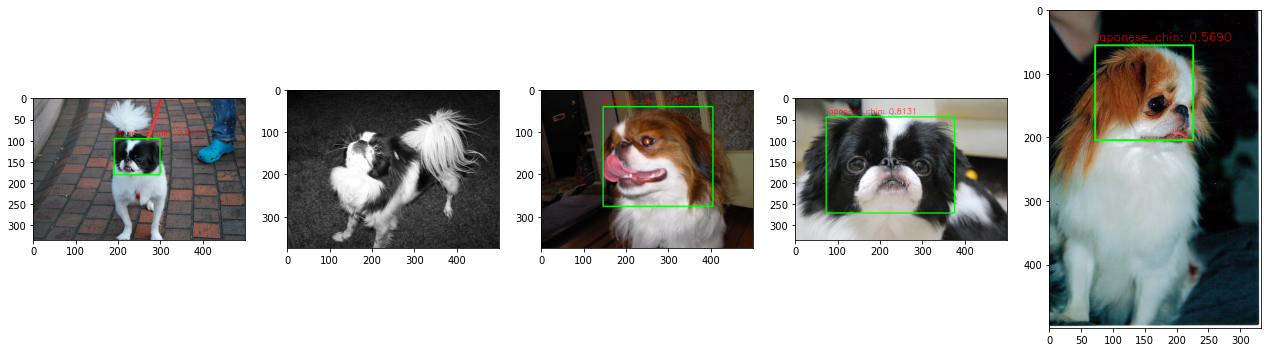

In [87]:
def show_detected_img(model, img_arrays, ncols=5):
    fig, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
      detected_img = get_detected_img(model, img_arrays[i], score_threshold=0.5)
      detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
      axes[i].imshow(detected_img)
        
show_detected_img(model_ckpt, val_imgs[:5], ncols=5)
show_detected_img(model_ckpt, val_imgs[5:10], ncols=5)

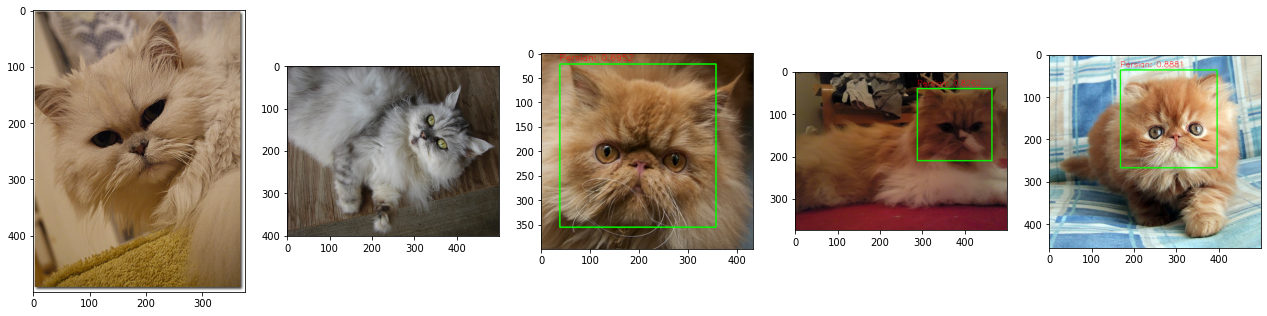

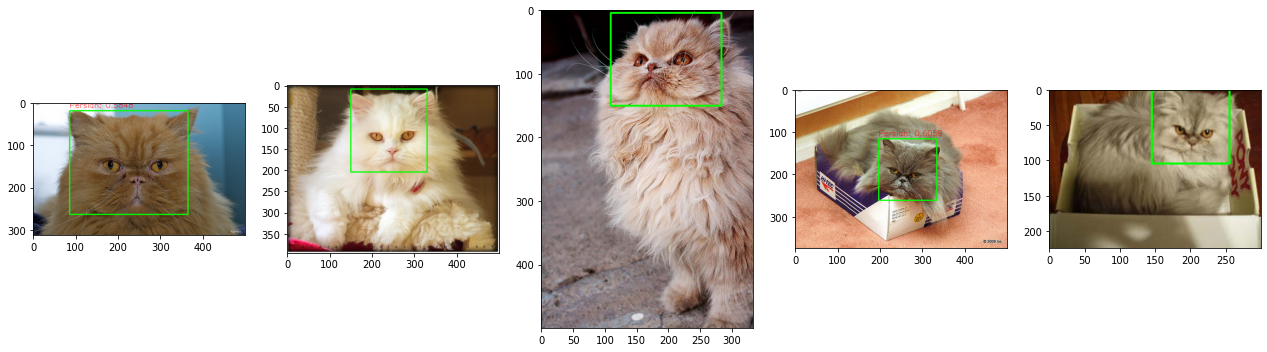

In [88]:
val_paths = val_df[val_df['img_path'].str.contains('Persian')]['img_path'].values
val_imgs = [cv2.imread(x) for x in val_paths]

show_detected_img(model_ckpt, val_imgs[:5], ncols=5)
show_detected_img(model_ckpt, val_imgs[5:10], ncols=5)